In [1]:
library(parallel)
detectCores(logical = FALSE)


[1] 32

In [2]:
system2("grep", "MemTotal /proc/meminfo", stdout = TRUE)

[1] "MemTotal:       2112594368 kB"

In [3]:
library(tidyverse)
library(Pando)
library(dplyr)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(hdf5r)
library(TFBSTools)
library(JASPAR2020)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg38’ was built under R version 4.3.3”
Loading required package: GenomeInfoDb

Warning 

In [4]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.4 (Seafoam Ocelot)

Matrix products: default
BLAS/LAPACK: /mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/.conda/envs/R/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] hdf5r_1.3.11                      EnsDb.Hsapiens.v86_2.99.0        
 [3] ensembldb_2.26.0                  AnnotationFilter_1.26.0          

In [5]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [6]:
inputdata.10x <- Read10X_h5("./PBMC/filtered_feature_bc_matrix.h5")

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [7]:
library(pryr)
mem_used()

Warning message:
"package 'pryr' was built under R version 4.3.3"

Attaching package: 'pryr'


The following object is masked from 'package:dplyr':

    where


The following objects are masked from 'package:purrr':

    compose, partial




2.19 GB

In [8]:
## Genome matrix has multiple modalities, returning a list of matrices for this genome
# extract RNA and ATAC data
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

In [9]:
# filter peaks by chromosome
atac_counts <- atac_counts[grep("chr", rownames(atac_counts)), ]

An object of class Seurat 
36601 features across 11426 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data

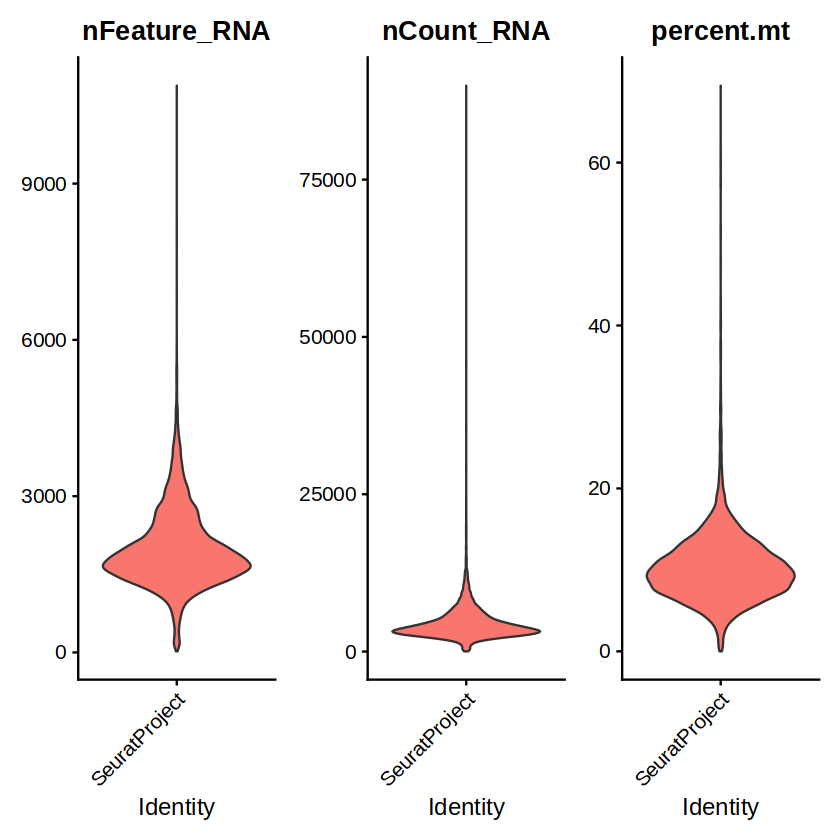

In [10]:
#Next, we create a Seurat object and filter low-quality cells from the scRNA-seq data.
obj.rna <- CreateSeuratObject(counts = rna_counts)
obj.rna <- NormalizeData(obj.rna, verbose = FALSE)
obj.rna[["percent.mt"]] <- PercentageFeatureSet(obj.rna, pattern = "^MT-")
# Visualize QC metrics as a violin plot
vln1<-VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)
vln1
obj.rna <- subset(obj.rna, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 20 & nCount_RNA < 13000)

obj.rna

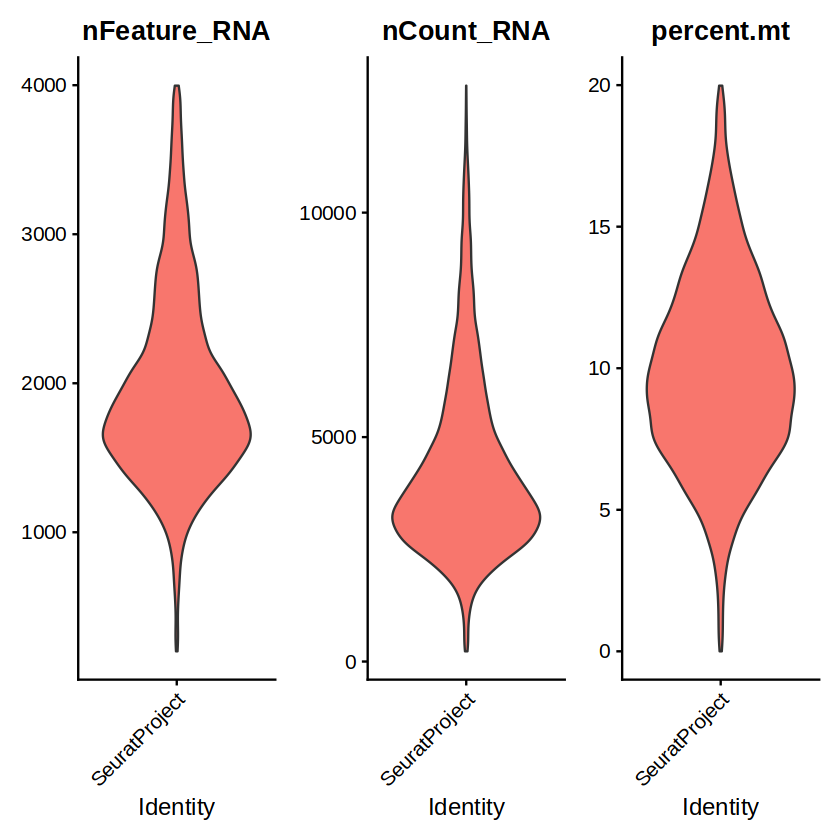

In [11]:
VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

In [12]:
# create seurat object
chrom_assay <- CreateChromatinAssay(
  counts = atac_counts,
  sep = c(":", "-"),
  min.cells = 1,
  genome = 'hg38',
  fragments = './PBMC/atac_fragments.tsv.gz'
)

Computing hash



In [13]:
obj.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "ATAC")

In [14]:
annotations<-readRDS("./models/R-scMEGA/annotations.rds")

In [16]:
# add the gene information to the object
Annotation(obj.atac) <- annotations

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



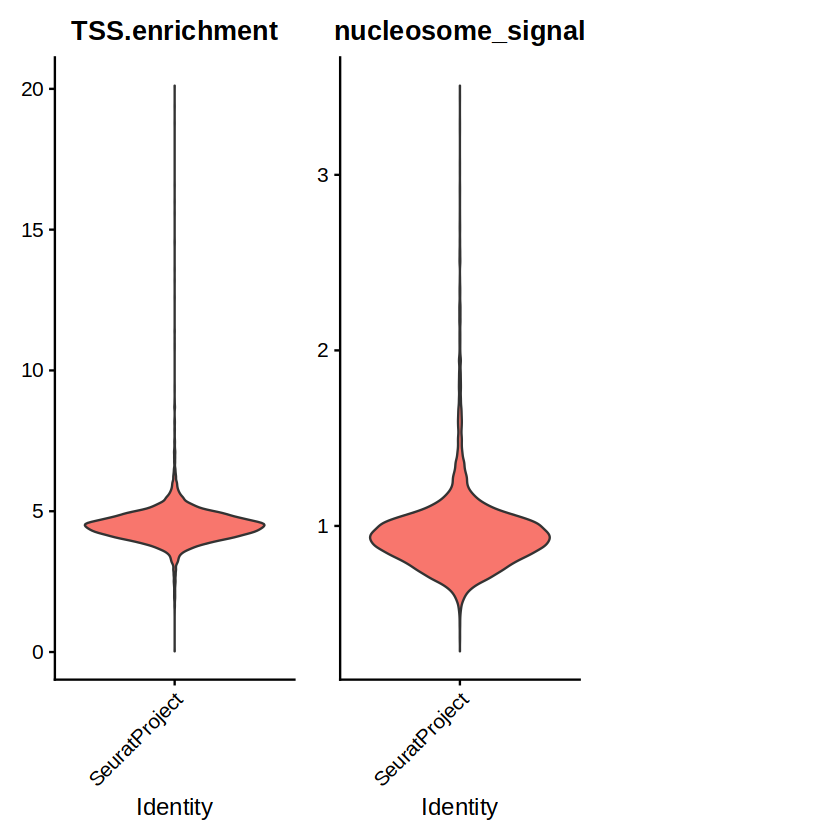

In [17]:
# TSS enrichment
obj.atac <- TSSEnrichment(obj.atac, fast = FALSE)

# Calculation of nucleosome signal
obj.atac <- NucleosomeSignal(obj.atac)



VlnPlot(
  obj.atac,
  features = c( "TSS.enrichment", "nucleosome_signal"),
  pt.size = 0,
  ncol = 3
)

In [18]:
obj.atac

An object of class Seurat 
107829 features across 11909 samples within 1 assay 
Active assay: ATAC (107829 features, 0 variable features)
 2 layers present: counts, data

In [19]:
# Filter low-quality cells
obj.atac <- subset(
  x = obj.atac,
  subset =
           nucleosome_signal < 4 & 
           TSS.enrichment > 2
)

In [20]:
obj.atac

An object of class Seurat 
107829 features across 11890 samples within 1 assay 
Active assay: ATAC (107829 features, 0 variable features)
 2 layers present: counts, data

In [21]:
cell.sel <- intersect(colnames(obj.rna), colnames(obj.atac))

In [22]:
obj.rna <- subset(obj.rna, cells = cell.sel)
obj.atac <- subset(obj.atac, cells = cell.sel)

In [23]:
#Next, we processed the scRNA-seq and scATAC-seq data using standard Seurat and Signac analysis pipelines:
# normalization followed by dimensionality reduction
obj.rna <- obj.rna %>%
  NormalizeData(verbose=FALSE) %>%
  FindVariableFeatures(nfeatures=3000, verbose=F) %>%
  ScaleData() %>%
  RunPCA(verbose = FALSE) %>%
  RunUMAP(dims = 1:30, verbose = FALSE)

obj.atac <- obj.atac %>%
  RunTFIDF() %>%
  FindTopFeatures() %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30, verbose = FALSE)

Centering and scaling data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



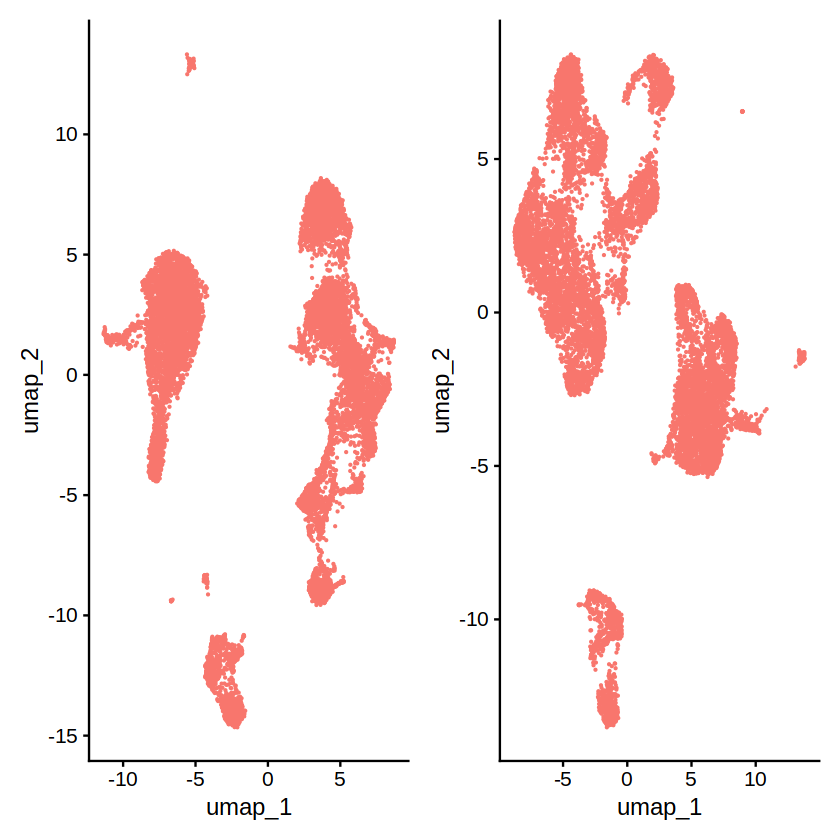

In [24]:
p1 <- DimPlot(obj.rna) + NoLegend()
p2 <- DimPlot(obj.atac) + NoLegend()

p1 + p2

In [25]:
setwd("./models/R-scMEGA")

In [26]:
reference <- readRDS("seurat.rds")
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Warning message:
"Assay RNA changing from Assay to Assay"
Warning message:
"Assay ATAC changing from Assay to Assay"
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [27]:
reference[["RNA"]] <- CreateAssayObject(counts = reference[["RNA"]]@counts)
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [28]:
# we only keep cells with annotated cell type
reference <- subset(reference, subset = celltype != "NA")

Warning message:
"Removing 1877 cells missing data for vars requested"


In [29]:
# run sctransform
reference <- reference %>%
    NormalizeData(verbose=FALSE) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData() %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

Centering and scaling data matrix



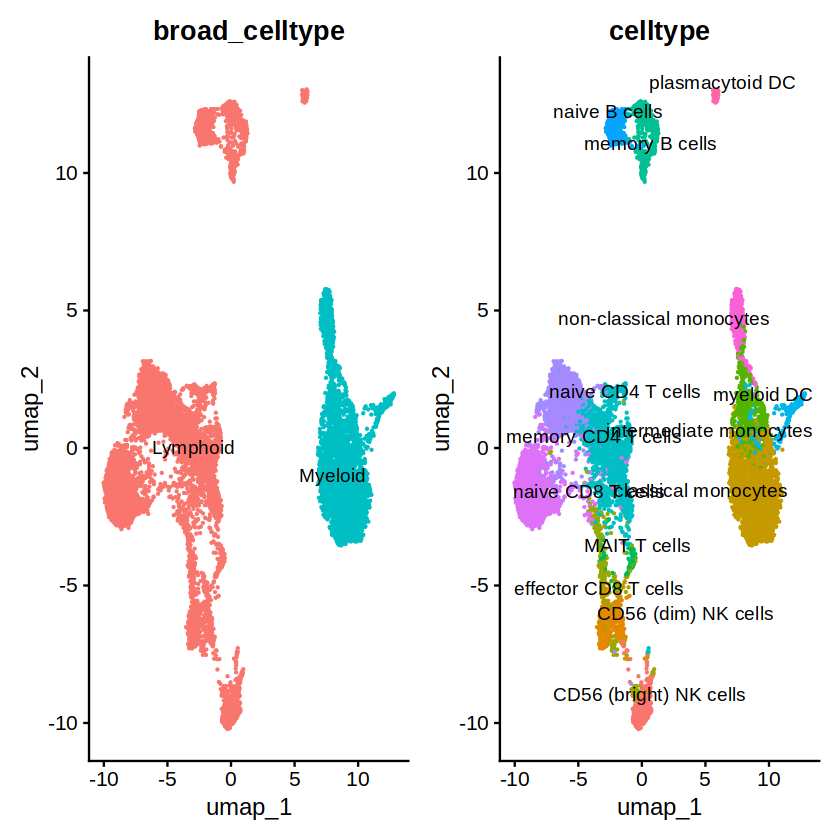

In [30]:
p1 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "broad_celltype") + NoLegend()

p2 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "celltype") + NoLegend()

p1 + p2

In [31]:
transfer_anchors <- FindTransferAnchors(
  reference = reference,
  query = obj.rna,
  reference.reduction = "pca",
  dims = 1:30
)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 27444 anchors



In [32]:
predictions <- TransferData(
  anchorset = transfer_anchors, 
  refdata = reference$celltype,
  weight.reduction = obj.rna[['pca']],
  dims = 1:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [33]:
obj.rna <- AddMetaData(
  object = obj.rna,
  metadata = predictions
)

obj.atac <- AddMetaData(
  object = obj.atac,
  metadata = predictions
)

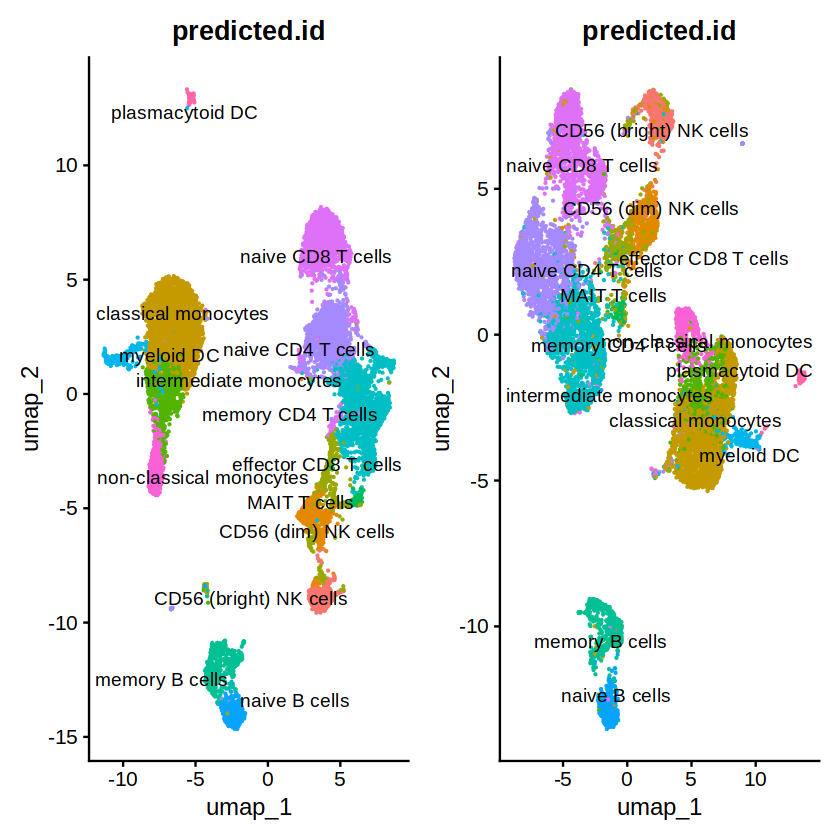

In [34]:
p1 <- DimPlot(obj.rna, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p2 <- DimPlot(obj.atac, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p1 + p2

In [35]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [36]:
meta.data <- obj.rna@meta.data %>%
    as.data.frame()


In [41]:
colnames(obj.rna@assays$RNA@layers$counts)<-colnames(obj.rna)

In [42]:
rownames(obj.rna@assays$RNA@layers$counts)<-rownames(obj.rna)

In [43]:
# create a Seurat object containing the RNA adata
pbmc <- CreateSeuratObject(
  counts = obj.rna@assays$RNA@layers$counts,
  assay = "RNA",
    meta.data = meta.data
)


In [46]:
# create ATAC assay and add it to the object
pbmc[["ATAC"]] <- CreateChromatinAssay(
  counts = obj.atac@assays$ATAC@counts,
  sep = c(":", "-"),
    min.cells = 1,
    genome = 'hg38',
    annotation=annotations,
    fragments = './PBMC/atac_fragments.tsv.gz'
)

Computing hash



In [47]:
## RNA pre-processing and PCA dimension reduction
DefaultAssay(pbmc) <- "RNA"

pbmc <- pbmc %>%
    NormalizeData(verbose=F) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData(verbose=F) %>%
    RunPCA(npcs=50, reduction.name="RNA_PCA", verbose=F)

In [48]:
## ATAC pre-processing and LSI dimension reduction
DefaultAssay(pbmc) <- "ATAC"

pbmc <- pbmc %>%
    RunTFIDF(verbose=F) %>%
    FindTopFeatures(min.cutoff = 'q0', verbose=F) %>%
    RunSVD(verbose=F)

In [219]:
pbmc

An object of class Seurat 
144412 features across 11414 samples within 2 assays 
Active assay: ATAC (107811 features, 107811 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: RNA_PCA, lsi

In [205]:
muo_data<-pbmc

In [138]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj"

In [200]:
muo_data
muo_data[['RNA']]
muo_data[['ATAC']]
data('phastConsElements20Mammals.UCSC.hg38')
data('SCREEN.ccRE.UCSC.hg38')

An object of class Seurat 
144412 features across 11414 samples within 2 assays 
Active assay: ATAC (107811 features, 107811 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: RNA_PCA, lsi

Assay (v5) data with 36601 features for 11414 cells
Top 10 variable features:
 PTGDS, SOX5, TCF4, IGKC, JCHAIN, CDKN1C, GNLY, LINC02694, IGHM,
LINC01478 
Layers:
 counts, data, scale.data 

ChromatinAssay data with 107811 features for 11414 cells
Variable features: 107811 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

# Performance Testing

In [202]:
library(peakRAM)

In [203]:
subsetByOverlaps(phastConsElements20Mammals.UCSC.hg38, SCREEN.ccRE.UCSC.hg38)

GRanges object with 502299 ranges and 3 metadata columns:
           seqnames              ranges strand |       idx        name
              <Rle>           <IRanges>  <Rle> | <numeric> <character>
       [1]     chr1   39845835-39845996      * |        13      lod=47
       [2]     chr1   84934642-84934658      * |        19      lod=15
       [3]     chr1 112197515-112197728      * |        22     lod=118
       [4]     chr1 177209331-177209405      * |        30      lod=26
       [5]     chr1 212860862-212860929      * |        34      lod=15
       ...      ...                 ...    ... .       ...         ...
  [502295]    chr22   50729748-50729779      * |       972      lod=17
  [502296]    chr22   50731592-50731785      * |       972     lod=203
  [502297]    chr22   50731824-50732000      * |       972     lod=139
  [502298]    chr22   50732168-50732256      * |       972      lod=48
  [502299]    chr22   50732344-50732453      * |       972      lod=30
               scor

In [206]:
result <- peakRAM({
muo_data <- initiate_grn(
  muo_data,
  rna_assay = 'RNA',
  peak_assay = 'ATAC',
  regions =  subsetByOverlaps(phastConsElements20Mammals.UCSC.hg38, SCREEN.ccRE.UCSC.hg38)
)
GetGRN(muo_data)
regions <- NetworkRegions(muo_data)
    
#Scanning for motifs
data('motifs')
data('motif2tf')    
    
pfm1 <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)
    
pattern_tfs1 <- sapply(pfm1, name)
    

motif2tf_use <- motif2tf %>%
    dplyr::filter(tf %in% pattern_tfs1)
motifs_use <- motifs[unique(motif2tf_use$motif)]
library(BSgenome.Hsapiens.UCSC.hg38)
muo_data <- find_motifs(
  muo_data, 
  pfm = motifs_use, 
  motif_tfs = motif2tf_use,
  genome = BSgenome.Hsapiens.UCSC.hg38
)
regions <- NetworkRegions(muo_data)
regions@motifs@data[1:5,1:5]
library(doParallel)
registerDoParallel(4)
muo_data <- infer_grn(
  muo_data,
  peak_to_gene_method = 'GREAT',
  genes = pattern_tfs1,
  parallel = T
)    
GetNetwork(muo_data)
coef(muo_data)    
muo_data <- find_modules(
  muo_data, 
  p_thresh = 0.05,
  nvar_thresh = 2, 
  min_genes_per_module = 1, 
  rsq_thresh = 0.1
)   
modules <- NetworkModules(muo_data) 
modules@meta    
})

print(result)

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
"Non-unique motif names supplied, making unique"
Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 558 target genes

Found 115 TF modules



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Function_Call
1 {muo_data<-initiate

# Start GRN

In [115]:
muo_data <- initiate_grn(
  muo_data,
  rna_assay = 'RNA',
  peak_assay = 'ATAC',
  regions = subsetByOverlaps(phastConsElements20Mammals.UCSC.hg38, SCREEN.ccRE.UCSC.hg38)
)

muo_data

An object of class "GRNData"
Slot "grn":
A RegulatoryNetwork object 
Candidate regions have not been scanned for motifs

No network has been inferred

Slot "data":
An object of class Seurat 
144412 features across 11414 samples within 2 assays 
Active assay: ATAC (107811 features, 107811 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: RNA_PCA, lsi


In [116]:
GetGRN(muo_data)

A RegulatoryNetwork object 
Candidate regions have not been scanned for motifs

No network has been inferred

In [117]:
regions <- NetworkRegions(muo_data)
regions@ranges

GRanges object with 285138 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1       181251-181601      *
       [2]     chr1       778562-778769      *
       [3]     chr1       779093-779355      *
       [4]     chr1       779727-779926      *
       [5]     chr1       817080-817370      *
       ...      ...                 ...    ...
  [285134]     chrX 155881685-155881888      *
  [285135]     chrX 155966975-155967181      *
  [285136]     chrX 155997445-155997580      *
  [285137]     chrX 155997788-155997809      *
  [285138]     chrY   11295678-11295744      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [91]:
#Scanning for motifs
data('motifs')
data('motif2tf')

In [92]:
motifs

PFMatrixList of length 1590
names(1590): M07783_2.00 M07784_2.00 M02651_2.00 ... UN0339.1 UN0340.1 UN0341.1

In [93]:
motif2tf

motif,tf,origin,gene_id,family,name,symbol,motif_tf
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
M07783_2.00,TFAP2D,CIS-BP,ENSG00000008197,AP-2,NA,NA,NA
M07784_2.00,TFAP2D,CIS-BP,ENSG00000008197,AP-2,NA,NA,NA
M02651_2.00,ARID3A,CIS-BP,ENSG00000116017,ARID/BRIGHT,NA,NA,NA
M08707_2.00,ARID5B,CIS-BP,ENSG00000150347,ARID/BRIGHT,NA,NA,NA
M00116_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01657_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01661_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01663_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01668_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA


In [95]:
pfm1 <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)


# Get the name of the transcription factor

In [96]:
pattern_tfs1 <- sapply(pfm1, name)

In [97]:
pattern_tfs1

MA0004.1              MA0006.1              MA0019.1 
               "Arnt"           "Ahr::Arnt"        "Ddit3::Cebpa" 
             MA0029.1              MA0030.1              MA0031.1 
              "Mecom"               "FOXF2"               "FOXD1" 
             MA0040.1              MA0041.1              MA0051.1 
              "Foxq1"               "Foxd3"                "IRF2" 
             MA0057.1              MA0059.1              MA0066.1 
        "MZF1(var.2)"            "MAX::MYC"               "PPARG" 
             MA0067.1              MA0069.1              MA0070.1 
               "Pax2"                "PAX6"                "PBX1" 
             MA0071.1              MA0072.1              MA0073.1 
               "RORA"         "RORA(var.2)"               "RREB1" 
             MA0074.1              MA0077.1              MA0078.1 
          "RXRA::VDR"                "SOX9"               "Sox17" 
             MA0084.1              MA0087.1              MA0091.1 
                "SRY"                "Sox5"          "TAL1::TCF3" 
             MA0092.1              MA0101.1              MA0107.1 
        "Hand1::Tcf3"                 "REL"                "RELA" 
             MA0108.2              MA0109.1              MA0111.1 
                "TBP"                "HLTF"                "Spz1" 
             MA0115.1              MA0116.1              MA0119.1 
        "NR1H2::RXRA"              "Znf423"          "NFIC::TLX1" 
             MA0125.1              MA0130.1              MA0135.1 
              "Nobox"             "ZNF354C"                "Lhx3" 
             MA0139.1              MA0142.1              MA0149.1 
               "CTCF"        "Pou5f1::Sox2"          "EWSR1-FLI1" 
             MA0138.2              MA0002.2              MA0065.2 
               "REST"               "RUNX1"         "Pparg::Rxra" 
             MA0151.1              MA0152.1              MA0155.1 
             "Arid3a"              "NFATC2"               "INSM1" 
             MA0159.1              MA0160.1              MA0163.1 
         "RARA::RXRA"               "NR4A2"               "PLAG1" 
             MA0164.1              MA0259.1              MA0146.2 
              "Nr2e3"         "ARNT::HIF1A"                 "Zfx" 
             MA0467.1              MA0468.1              MA0476.1 
                "Crx"                "DUX4"                 "FOS" 
             MA0478.1              MA0479.1              MA0480.1 
              "FOSL2"               "FOXH1"               "Foxo1" 
             MA0483.1              MA0488.1              MA0489.1 
              "Gfi1b"                 "JUN"          "JUN(var.2)" 
             MA0492.1              MA0493.1              MA0494.1 
        "JUND(var.2)"                "Klf1"         "Nr1h3::Rxra" 
             MA0497.1              MA0501.1              MA0503.1 
              "MEF2C"           "MAF::NFE2"       "Nkx2-5(var.2)" 
             MA0504.1              MA0505.1              MA0506.1 
              "NR2C2"               "Nr5a2"                "NRF1" 
             MA0507.1              MA0513.1              MA0514.1 
             "POU2F2" "SMAD2::SMAD3::SMAD4"                "Sox3" 
             MA0515.1              MA0517.1              MA0518.1 
               "Sox6"        "STAT1::STAT2"               "Stat4" 
             MA0519.1              MA0520.1              MA0521.1 
     "Stat5a::Stat5b"               "Stat6"               "Tcf12" 
             MA0523.1              MA0527.1              MA0076.2 
             "TCF7L2"              "ZBTB33"                "ELK4" 
             MA0258.2              MA0050.2              MA0150.2 
               "ESR2"                "IRF1"              "Nfe2l2" 
             MA0137.3              MA0144.2              MA0140.2 
              "STAT1"               "STAT3"         "GATA1::TAL1" 
             MA0095.2              MA0591.1              MA0593.1 
                "YY1"         "Bach1::Mafk"               "F

In [98]:
motif2tf_use <- motif2tf %>%
    dplyr::filter(tf %in% pattern_tfs1)
motifs_use <- motifs[unique(motif2tf_use$motif)]
motif2tf_use

motif,tf,origin,gene_id,family,name,symbol,motif_tf
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
M03447_2.00,NFAT5,CIS-BP,ENSG00000102908,Rel,NA,NA,NA
M05709_2.00,NFAT5,CIS-BP,ENSG00000102908,Rel,NA,NA,NA
M05710_2.00,NFAT5,CIS-BP,ENSG00000102908,Rel,NA,NA,NA
M09371_2.00,RUNX1,CIS-BP,ENSG00000159216,Runt,NA,NA,NA
M09631_2.00,RUNX1,CIS-BP,ENSG00000159216,Runt,NA,NA,NA
M09632_2.00,RUNX1,CIS-BP,ENSG00000159216,Runt,NA,NA,NA
MA0030.1,FOXF2,JASPAR2020,NA,Forkhead box (FOX) factors,FOXF2,FOXF2,NA
MA0031.1,FOXD1,JASPAR2020,NA,Forkhead box (FOX) factors,FOXD1,FOXD1,NA
MA0051.1,IRF2,JASPAR2020,NA,Interferon-regulatory factors,IRF2,IRF2,NA


In [99]:
motifs_use

PFMatrixList of length 633
names(633): M03447_2.00 M05709_2.00 M05710_2.00 ... UN0118.1 UN0307.1 UN0308.1

In [100]:
library(BSgenome.Hsapiens.UCSC.hg38)
muo_data <- find_motifs(
  muo_data, 
  pfm = motifs_use, 
  motif_tfs = motif2tf_use,
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
"Non-unique motif names supplied, making unique"


In [101]:
regions <- NetworkRegions(muo_data)
regions@motifs@data[1:5,1:5]

5 x 5 sparse Matrix of class "lgCMatrix"
                   M03447_2.00 M05709_2.00 M05710_2.00 M09371_2.00 M09631_2.00
chr1-181251-181601           .           .           .           .           .
chr1-778562-778769           .           .           .           .           .
chr1-779093-779355           .           .           .           .           .
chr1-779727-779926           .           .           .           .           |
chr1-817080-817370           .           .           .           .           .

In [185]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj"

In [186]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/models/R-pando')

# Infer grn

In [103]:
library(doParallel)
registerDoParallel(4)

In [105]:
muo_data <- infer_grn(
  muo_data,
  peak_to_gene_method = 'GREAT',
  genes = pattern_tfs1,
  parallel = T
)

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 558 target genes



In [223]:
GetNetwork(muo_data)
coef(muo_data)

A Network object
with 115 TFs and 55 target genes

tf,target,region,term,estimate,std_err,statistic,pval,padj,corr
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GATA2,GATA1,chrX-48789656-48789740,chrX_48789656_48789740:GATA2,-0.0316495845,0.008434566,-3.75236659,1.760412e-04,2.362436e-03,0.1984945
GATA2,GATA1,chrX-48800987-48801123,GATA2:chrX_48800987_48801123,-0.5746847785,0.083816672,-6.85644946,7.423706e-12,2.709337e-10,0.1984945
GATA2,GATA1,chrX-48920519-48920614,GATA2:chrX_48920519_48920614,0.5092017484,0.036228033,14.05546212,1.675249e-44,1.340511e-42,0.1984945
GATA2,GATA1,chrX-48941825-48942068,GATA2:chrX_48941825_48942068,0.5936801323,0.164124951,3.61724484,2.990412e-04,3.718676e-03,0.1984945
KLF4,TFE3,chrX-48531553-48531949,chrX_48531553_48531949:KLF4,-0.0072222234,0.006925662,-1.04282065,2.970535e-01,6.005870e-01,0.1110898
KLF4,TFE3,chrX-48535810-48535916,KLF4:chrX_48535810_48535916,0.0022370034,0.006770009,0.33042841,7.410824e-01,9.029948e-01,0.1110898
KLF4,TFE3,chrX-48597373-48597396,KLF4:chrX_48597373_48597396,0.0218894935,0.007066357,3.09770570,1.954995e-03,1.844379e-02,0.1110898
SPI1,TFE3,chrX-48683718-48683778,chrX_48683718_48683778:SPI1,0.0127686722,0.005167091,2.47115276,1.348235e-02,8.531096e-02,0.1013089
SPI1,TFE3,chrX-48918646-48918677,SPI1:chrX_48918646_48918677,0.0043353450,0.011424375,0.37948201,7.043370e-01,8.864319e-01,0.1013089


# Module discovery

In [207]:
muo_data <- find_modules(
  muo_data, 
  p_thresh = 0.05,
  nvar_thresh = 2, 
  min_genes_per_module = 1, 
  rsq_thresh = 0.1
)

Found 115 TF modules



In [224]:
modules <- NetworkModules(muo_data) 
modules@meta

tf,target,estimate,n_regions,n_genes,n_tfs,regions,pval,padj
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
ATF3,ETV6,0.10831493,20,8,20,chr12-11653669-11653688,1.155598e-03,1.193871e-02
ATF3,FOXO3,0.10513226,14,8,16,chr6-108558366-108558649,4.282982e-04,5.118521e-03
ATF3,KLF4,0.05296403,26,8,28,chr9-108272091-108272367,2.909797e-04,3.621925e-03
ATF3,MEF2A,-0.08068337,20,8,16,chr15-98823271-98823313,1.785986e-03,1.714520e-02
ATF3,NR4A1,0.09441619,16,8,15,chr12-52064220-52064406,5.042540e-10,1.592231e-08
ATF3,NR4A2,0.24921997,10,8,11,chr2-156332721-156332909,2.193191e-16,1.001946e-14
ATF3,TCF7,-0.09621773,20,8,20,chr5-134412433-134412454,2.699416e-03,2.395081e-02
ATF3,TFEC,0.13858316,21,8,15,chr7-116211546-116211567,7.212647e-13,2.815773e-11
BACH1,ATF3,0.01374147,20,19,19,chr1-212234738-212234852;chr1-212567248-212567431;chr1-212605646-212605802,2.833942e-11,1.003013e-09


In [229]:
max(modules@meta['n_tfs'])

[1] 29

In [222]:
GetNetwork(muo_data)


A Network object
with 115 TFs and 55 target genes

Warning message:
"Using alpha for a discrete variable is not advised."


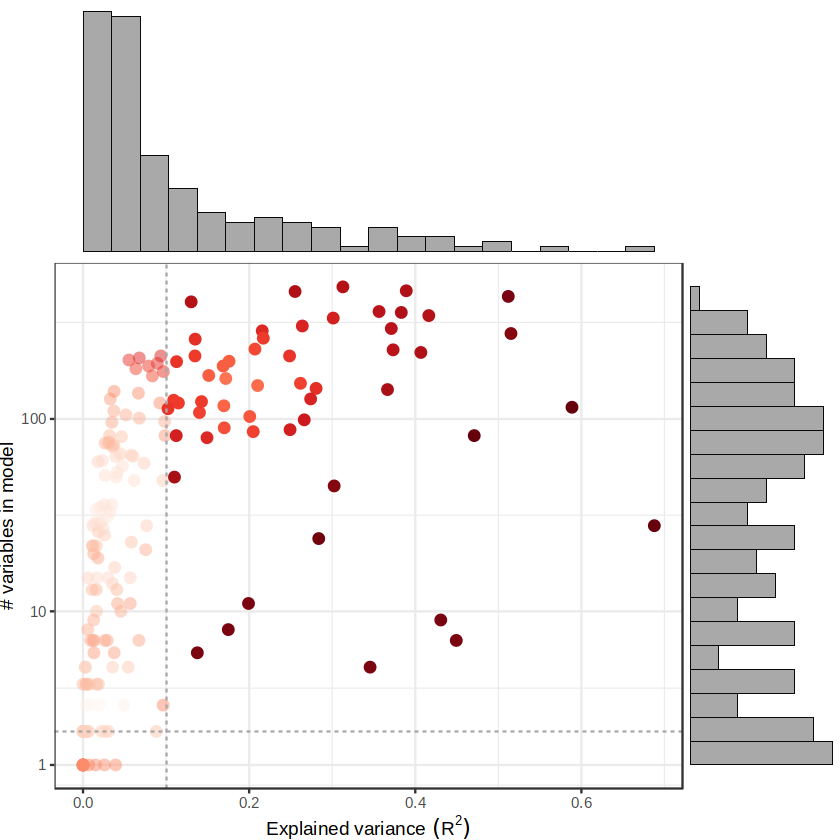

In [209]:
a<-plot_gof(muo_data, point_size=3)
a
#ggsave(filename='plot1.png',plot=a,width=8,height=8,dpi=300)

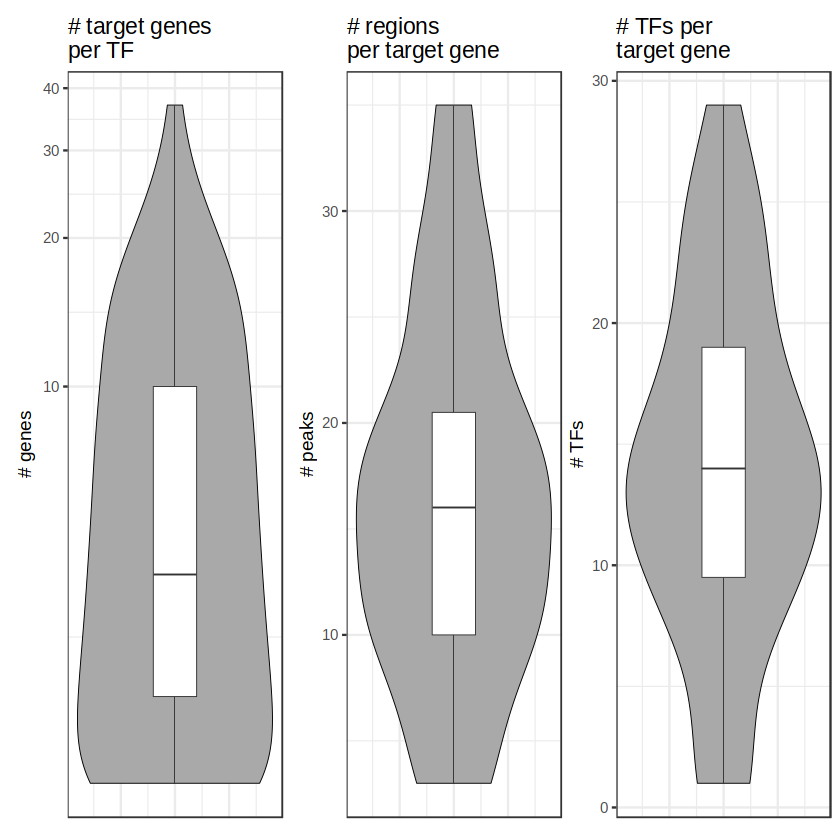

In [210]:
b<-plot_module_metrics(muo_data)
b
#ggsave(filename='plot2.png',plot=b,width=8,height=8,dpi=300)

# Visualizing the GRN

Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
"You're computing too large a percentage of total singular values, use a standard svd instead."
Getting network graph



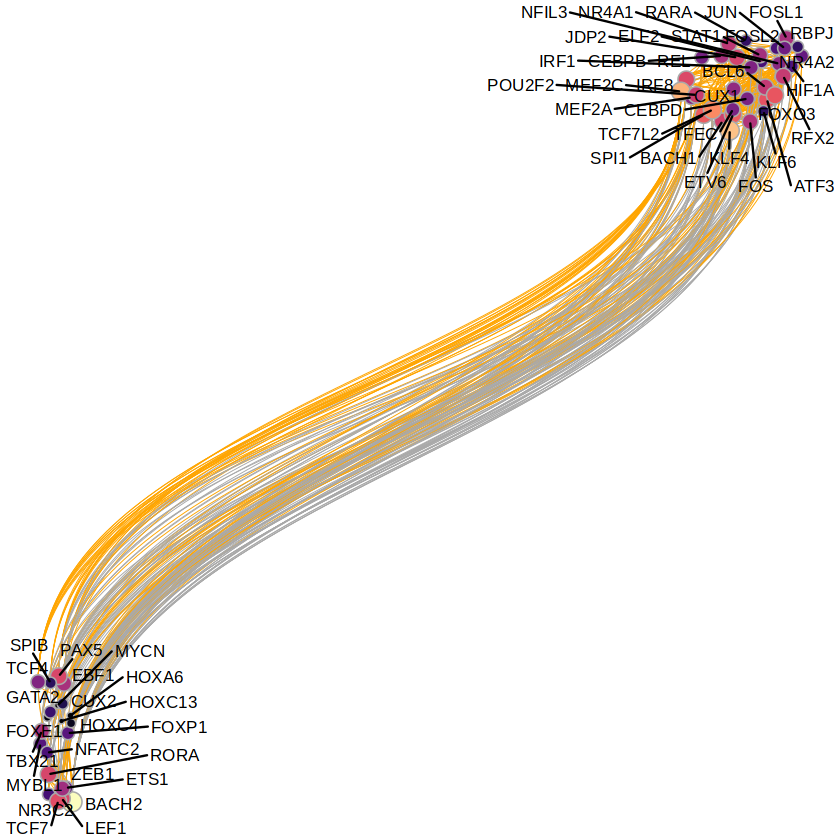

In [211]:
muo_data <- get_network_graph(muo_data)
p3<-plot_network_graph(muo_data)
p3
#ggsave(filename='plot3.png',plot=p3,width=8,height=8,dpi=600)

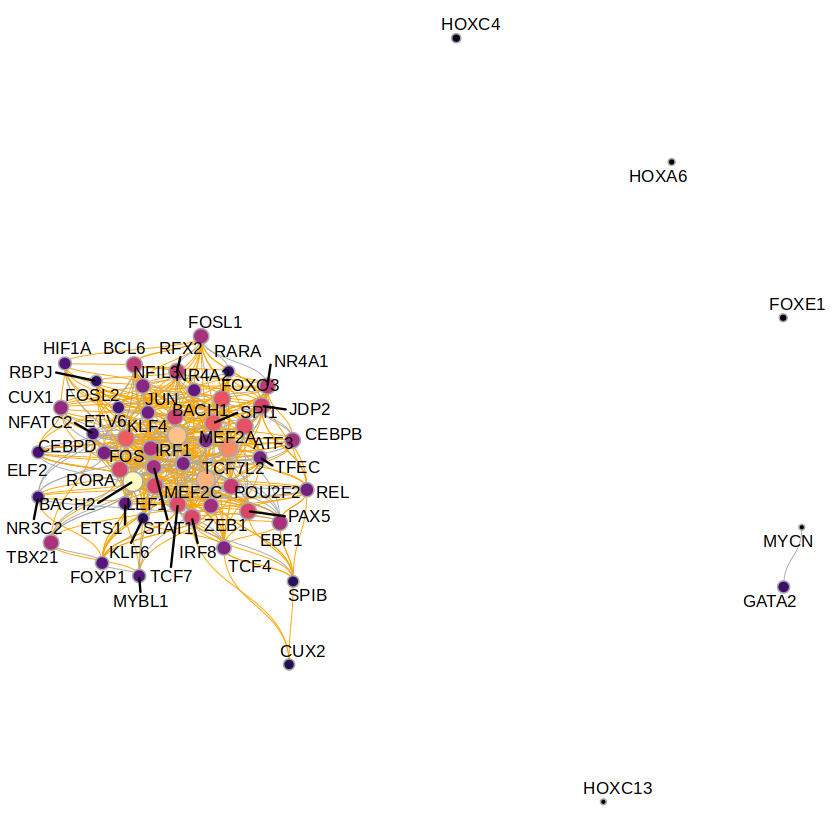

In [212]:
p4<-plot_network_graph(muo_data, layout='fr')
p4
#ggsave(filename='plot4.png',plot=p4,width=8,height=8,dpi=600)

In [213]:
muo_data <- get_network_graph(muo_data, graph_name='umap_graph')

Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
"You're computing too large a percentage of total singular values, use a standard svd instead."
Getting network graph



In [214]:
muo_data <- get_network_graph(
    muo_data, 
    graph_name = 'full_graph', 
    umap_method = 'none'
)

Getting network graph



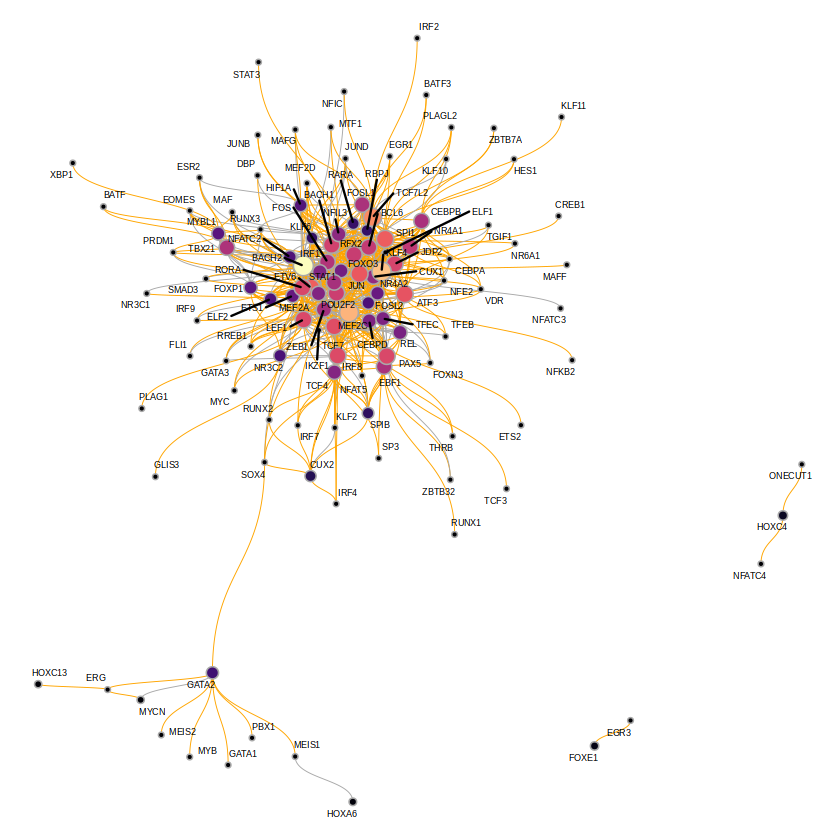

In [215]:
p5 <- plot_network_graph(muo_data, graph='full_graph', layout='fr', text_size=5)
p5
#ggsave(filename='plot5.png',plot=p5,width=8,height=8,dpi=600)

Getting shortest paths from TF

Pruning graph



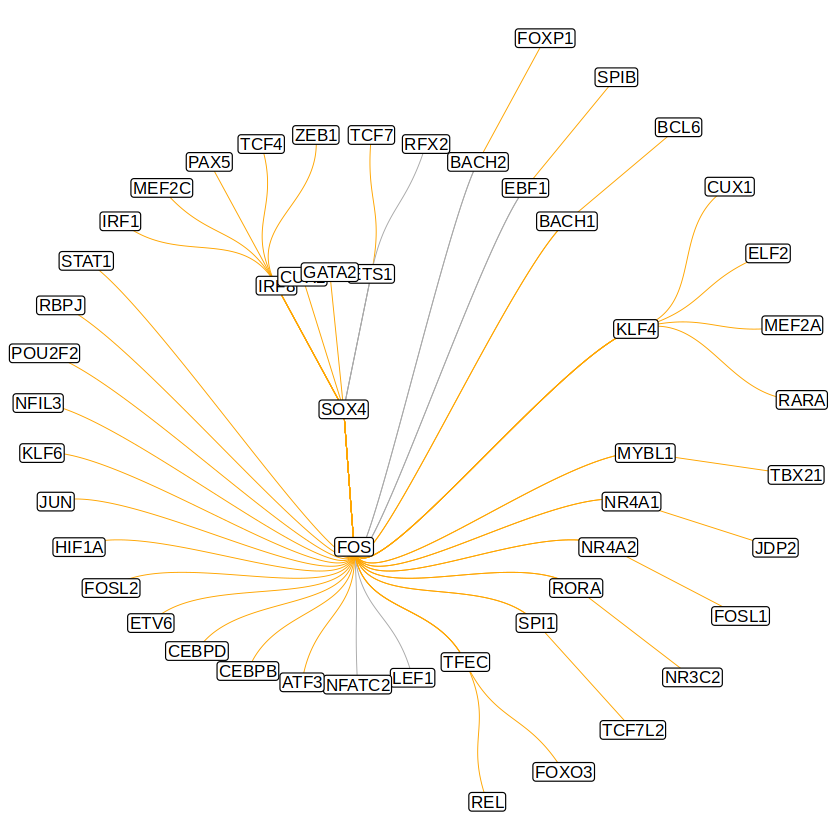

In [216]:
muo_data <- get_tf_network(muo_data, tf='SOX4', graph='full_graph')
p7<-plot_tf_network(muo_data, tf='SOX4')
p7
#ggsave(filename='plot7.png',plot=p7,width=8,height=8,dpi=300)

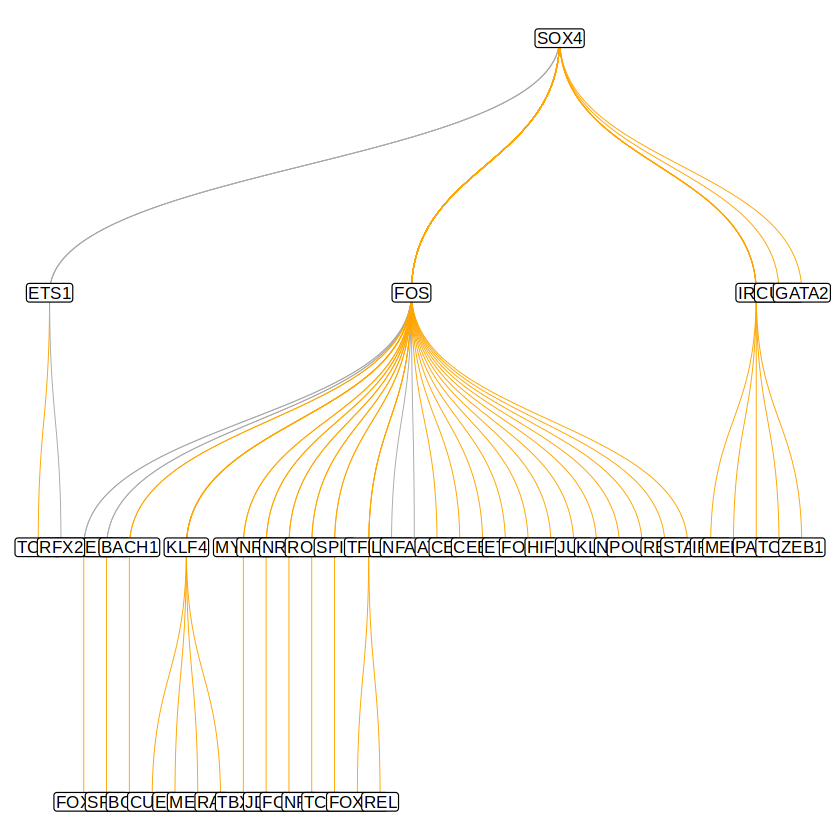

In [217]:
p8<-plot_tf_network(muo_data, tf='SOX4', circular=F)
p8
#ggsave(filename='plot8.png',plot=p8,width=8,height=8,dpi=300)

In [218]:
library(pryr)
mem_used()

12.8 GB